## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input

## Loading Data<br>
Loading training and testing data

In [2]:
cols = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'])

In [4]:
train_data = pd.read_csv('KDDTrain+.txt', names=cols)
test_data = pd.read_csv('KDDTest+.txt', names=cols)

## Data Preprocessing<br>
Scaling the numerical data

In [5]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

Listing out categorical columns for making numerical columns dataframe

In [6]:
cat_cols = ['is_host_login', 'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_guest_login', 'difficulty', 'label']

Function for data preprocessing

In [7]:
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    # Assigning 0/1 values to labels columns
    dataframe.loc[dataframe['label'] == "normal", "label"] = 0
    dataframe.loc[dataframe['label'] != 0, "label"] = 1
    dataframe = pd.get_dummies(dataframe, columns=['protocol_type', 'service', 'flag'])
    return dataframe

Preprocessing the training dataset

In [8]:
train_scaled = preprocess(train_data)

## Separating Features and Labels<br>
Separating features (x) and labels (y)

In [9]:
x = train_scaled.drop(['label', 'difficulty'], axis=1).values
y = train_scaled['label'].values
y_reg = train_scaled['difficulty'].values

## Imputing Missing Values<br>
Imputing missing values

In [10]:
imputer = SimpleImputer(strategy='mean')
x = imputer.fit_transform(x)

## Dimensionality Reduction with PCA<br>
Dimensionality reduction with PCA

In [11]:
pca = PCA(n_components=20)
x_reduced = pca.fit_transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

Number of original features is 122 and of reduced features is 20


Check for NaN values in the reduced dataset

In [12]:
if np.isnan(x_reduced).any():
    print("Warning: NaN values exist in the reduced dataset. Dropping rows with NaN values.")
    nan_rows_reduced = np.isnan(x_reduced).any(axis=1)
    x_reduced = x_reduced[~nan_rows_reduced]

Convert labels to integers

In [13]:
y = y.astype('int')

## Splitting Data into Training and Testing Sets<br>
Splitting the data into training and testing sets

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

Number of original features is 122 and of reduced features is 20


## Model Evaluation Dictionary<br>
Dictionary to store model evaluations for later comparisons

In [15]:
model_evals = dict()

## Function to Evaluate Classification Models<br>
Function to evaluate classification models

In [18]:
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    if name == "OneClassSVM":
        # For OneClassSVM, we consider only the normal class (0) in evaluation
        y_train = y_train[y_train == 0]
        y_test = y_test[y_test == 0]
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='binary')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='binary')
    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='binary')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='binary')
    model_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Train accuracy for {} is {} and test accuracy is {}".format(name, train_accuracy * 100, test_accuracy * 100))
    print("Train precision for {} is {} and test precision is {}".format(name, train_precision * 100, test_precision * 100))
    print("Train recall for {} is {} and test recall is {}".format(name, train_recall * 100, test_recall * 100))
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    # Plot Confusion Matrix using Plotly
    fig = go.Figure()
    fig.add_trace(go.Heatmap(z=confusion_matrix, x=['Normal', 'Attack'], y=['Normal', 'Attack'], colorscale='Viridis'))
    fig.update_layout(
        title=f'{name} Confusion Matrix',
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        width=500,
        height=500
    )
    fig.show()
    return [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]

## KNeighbors Classifier<br>
A KNeighborsClassifier model with 20 neighbors

In [19]:
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

Evaluating the KNeighborsClassifier model using the evaluate_classification function

In [20]:
knn_result = evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

Train accuracy for KNeighborsClassifier is 99.02260413979242 and test accuracy is 98.8727922206787
Train precision for KNeighborsClassifier is 99.18089029933957 and test precision is 99.01868760133117
Train recall for KNeighborsClassifier is 98.71310583263974 and test recall is 98.56451201902658


Storing the result in model_evals dictionary

In [21]:
model_evals["KNN"] = knn_result

## Random Forest Classifier<br>
Create a RandomForestClassifier model

In [22]:
rf = RandomForestClassifier().fit(x_train, y_train)

Evaluating the RandomForestClassifier model

In [23]:
rf_result = evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

Train accuracy for RandomForestClassifier is 99.99801543987775 and test accuracy is 99.87695971422902
Train precision for RandomForestClassifier is 99.9957318764805 and test precision is 99.95745405037441
Train recall for RandomForestClassifier is 100.0 and test recall is 99.77915569523486


Storing the result in model_evals dictionary

In [24]:
model_evals["RandomForestClassifier"] = rf_result

## Displaying the Results<br>
Displaying the results

In [25]:
model_evals_df = pd.DataFrame.from_dict(model_evals, orient='index', columns=['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall'])
print("Model Evaluation Results:")
print(model_evals_df)

Model Evaluation Results:
                        Train Accuracy  Test Accuracy  Train Precision  \
KNeighborsClassifier          0.990226       0.988728         0.991809   
KNN                           0.990226       0.988728         0.991809   
RandomForestClassifier        0.999980       0.998770         0.999957   

                        Test Precision  Train Recall  Test Recall  
KNeighborsClassifier          0.990187      0.987131     0.985645  
KNN                           0.990187      0.987131     0.985645  
RandomForestClassifier        0.999575      1.000000     0.997792  


## Autoencoder<br>
Function to create and train an autoencoder model

In [26]:
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(20, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

Function to evaluate the autoencoder model

In [27]:
def evaluate_autoencoder(model, X_train, X_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    mse_train = np.mean(np.power(X_train - train_predictions, 2), axis=1)
    mse_test = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    return mse_train, mse_test

Train the autoencoder model

In [28]:
autoencoder_input_dim = x_train.shape[1]
autoencoder = create_autoencoder(autoencoder_input_dim)
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)

Evaluate the autoencoder model

In [29]:
mse_train, mse_test = evaluate_autoencoder(autoencoder, x_train, x_test)

788/788 [==============================] - 1s 1ms/step


Add the results to the model_evals dictionary

In [30]:
model_evals["Autoencoder"] = {"MSE Train": mse_train, "MSE Test": mse_test}

Display the autoencoder evaluation results

In [31]:
print("Autoencoder evaluation results:")
print("MSE Train: Mean = {:.4f}, Std = {:.4f}".format(np.mean(mse_train), np.std(mse_train)))
print("MSE Test: Mean = {:.4f}, Std = {:.4f}".format(np.mean(mse_test), np.std(mse_test)))

Autoencoder evaluation results:
MSE Train: Mean = 4890329.8443, Std = 829202271.0530
MSE Test: Mean = 1750529.0411, Std = 262032035.1146


## One-Class SVM<br>
Creating and training the One-Class SVM model

In [32]:
ocsvm = OneClassSVM(nu=0.01)  # Adjust the hyperparameter 'nu' as needed
ocsvm.fit(x_train)

OneClassSVM(nu=0.01)

Function to evaluate the One-Class SVM model

In [35]:
def evaluate_ocsvm(model, X_train, X_test, y_train, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Converting predictions to binary labels (1 for inliers, -1 for outliers)
    train_labels = [1 if pred == 1 else 0 for pred in train_predictions]
    test_labels = [1 if pred == 1 else 0 for pred in test_predictions]

    # Evaluation metrics
    train_accuracy = metrics.accuracy_score(y_train, train_labels)
    test_accuracy = metrics.accuracy_score(y_test, test_labels)
    train_precision = metrics.precision_score(y_train, train_labels)
    test_precision = metrics.precision_score(y_test, test_labels)
    train_recall = metrics.recall_score(y_train, train_labels)
    test_recall = metrics.recall_score(y_test, test_labels)

    # Confusion Matrix
    confusion_matrix_train = metrics.confusion_matrix(y_train, train_labels)
    confusion_matrix_test = metrics.confusion_matrix(y_test, test_labels)

    # Display Confusion Matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(confusion_matrix_train, annot=True, fmt="d", cmap="Blues", ax=ax1)
    ax1.set_title("Train Set Confusion Matrix")
    ax1.set_xticklabels(['Normal', 'Attack'])
    ax1.set_yticklabels(['Normal', 'Attack'])
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    sns.heatmap(confusion_matrix_test, annot=True, fmt="d", cmap="Blues", ax=ax2)
    ax2.set_title("Test Set Confusion Matrix")
    ax2.set_xticklabels(['Normal', 'Attack'])
    ax2.set_yticklabels(['Normal', 'Attack'])
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    plt.show()
    return {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall
    }

Evaluate the One-Class SVM model

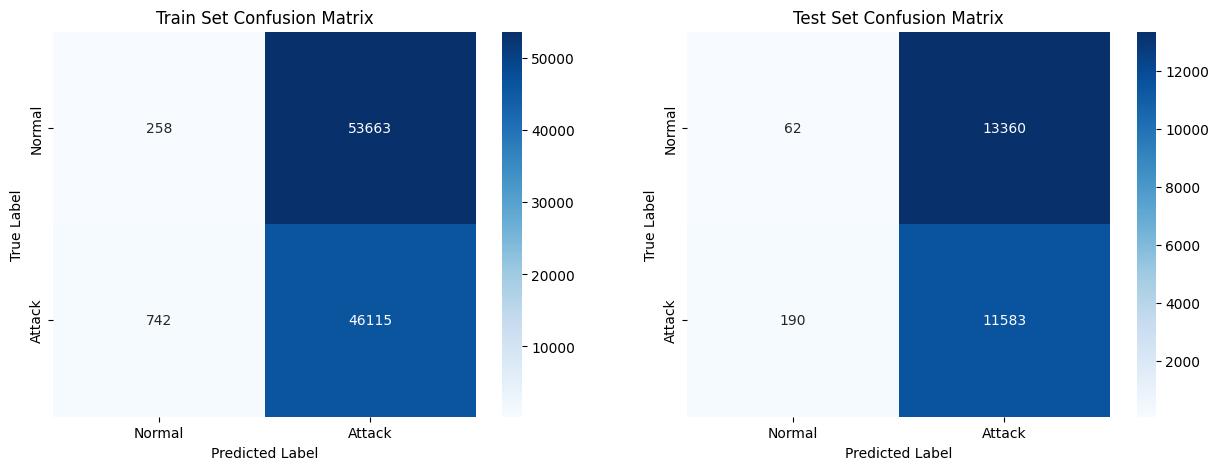

In [36]:
ocsvm_result = evaluate_ocsvm(ocsvm, x_train, x_test, y_train, y_test)

Store the results in the model_evals dictionary

In [37]:
model_evals["OneClassSVM"] = ocsvm_result

Display the One-Class SVM evaluation results

In [38]:
print("One-Class SVM evaluation results:")
for metric, value in ocsvm_result.items():
    print(f"{metric}: {value}")

One-Class SVM evaluation results:
Train Accuracy: 0.460150032745242
Test Accuracy: 0.46219487993649533
Train Precision: 0.4621760307883501
Test Precision: 0.4643787836266688
Train Recall: 0.9841645858676399
Test Recall: 0.9838613777287013


## Isolation Forest<br>
Create Isolation Forest model

In [39]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)

Train-test split

In [40]:
x_train_iso, x_test_iso, y_train_iso, y_test_iso = train_test_split(x, y, test_size=0.2, random_state=42)

Train the Isolation Forest model

In [41]:
iso_forest.fit(x_train_iso)

IsolationForest(contamination=0.05, random_state=42)

Predict on training and testing sets

In [42]:
train_preds_iso = iso_forest.predict(x_train_iso)
test_preds_iso = iso_forest.predict(x_test_iso)

Convert predictions to binary labels (1: inlier, -1: outlier)

In [43]:
train_labels_iso = np.where(train_preds_iso == 1, 0, 1)
test_labels_iso = np.where(test_preds_iso == 1, 0, 1)

Calculate and print evaluation metrics

In [44]:
train_accuracy_iso = metrics.accuracy_score(y_train_iso, train_labels_iso)
test_accuracy_iso = metrics.accuracy_score(y_test_iso, test_labels_iso)

In [45]:
train_precision_iso = metrics.precision_score(y_train_iso, train_labels_iso)
test_precision_iso = metrics.precision_score(y_test_iso, test_labels_iso)

In [46]:
train_recall_iso = metrics.recall_score(y_train_iso, train_labels_iso)
test_recall_iso = metrics.recall_score(y_test_iso, test_labels_iso)

In [47]:
print("Isolation Forest Evaluation Metrics:")
print("Training Accuracy: {:.2f}%".format(train_accuracy_iso * 100))
print("Testing Accuracy: {:.2f}%".format(test_accuracy_iso * 100))
print("Training Precision: {:.2f}".format(train_precision_iso))
print("Testing Precision: {:.2f}".format(test_precision_iso))
print("Training Recall: {:.2f}".format(train_recall_iso))
print("Testing Recall: {:.2f}".format(test_recall_iso))

Isolation Forest Evaluation Metrics:
Training Accuracy: 55.25%
Testing Accuracy: 54.95%
Training Precision: 0.67
Testing Precision: 0.67
Training Recall: 0.07
Testing Recall: 0.07
